In [1]:
import requests
import datetime
from bs4 import BeautifulSoup
import re
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='NanumGothic')
api_key = '...'# 일반인증키(Decode 필요)

In [2]:
def get_data(xml_data, columnName) :
    rows = xml_data.findAll('item')
    
    # 돌아가는 코드 확인
    # print(rows[0].find_all()[0].name)
    # print(rows[0].find_all()[0].text.strip())

    rowList = []
    nameList = []
    columnList = []

    rowsLen = len(rows)

    for i in range(0, rowsLen):
        for j in columnName:
            #### Column 별 data 수집하기 (Row 데이터 생성)
            try :
                eachColumn = rows[i].find(j).text.strip() # column 내 순서대로 값들 추출
            except :
                eachColumn = np.nan

            columnList.append(eachColumn) # 추출한 값들을 list 형태로 저장, 다 저장되면 1개 row의 모든 값들 저장 완성

        ### Row 데이터 누적
        rowList.append(columnList) # 위에서 완성된 row data를 rowList에 저장하여 1개씩 row 누적 완성
        columnList = []

    result = pd.DataFrame(rowList, columns=columnName) # 값 자체가 row로 누적되었고, nameList는 column 명임
    
    result['거래금액'] = result['거래금액'].str.replace(',','').astype(int)
    result = result[['거래금액','건축년도','아파트', '월', '일', '전용면적', '층']]
    result[['거래금액','건축년도', '월', '일', '층']] = result[['거래금액','건축년도', '월', '일', '층']].astype(int)
    result['전용면적'] = result['전용면적'].astype(float)
    
    return result

# 전체 법정동 코드 갖고오기

https://www.code.go.kr/index.do (여기서 다운)

In [3]:
gu_cd = pd.read_csv('법정동코드 전체자료.txt', encoding='euc-kr', sep='\t')

# # 2개 방법 존재
# gu_cd.loc[gu_cd['법정동명'].str.contains('(구$)', regex=True),] # 1번
# r = re.compile('구$') # 2번
# gu_cd['법정동명'].apply(lambda x : True if r.search(x) else False)

temp_gu = gu_cd.loc[(gu_cd['법정동명'].str.contains('서울특별시'))&(gu_cd['법정동명'].str.contains('(구$)', regex=True)),'법정동코드'].astype(str)
gu_df = gu_cd.loc[(gu_cd['법정동명'].str.contains('서울특별시'))&(gu_cd['법정동명'].str.contains('(구$)', regex=True)),['법정동코드', '법정동명']]
gu_list = temp_gu.apply(lambda x : str(x)[:5]).values.tolist()

gu_df['법정동명'] = gu_df['법정동명'].str.split(' ', expand=True)[1]
gu_df['법정동코드'] = gu_list

# API 로 서울 모든 구, 실매매 데이터 갖고오기

In [4]:
todayM = datetime.datetime.now().strftime('%Y%m')
url = 'http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev'
columnName = ['거래금액', '거래유형', '건축년도', '년', '도로명', '도로명건물본번호코드', '도로명건물부번호코드',
       '도로명시군구코드', '도로명일련번호코드', '도로명지상지하코드', '도로명코드', '법정동', '법정동본번코드',
       '법정동부번코드', '법정동시군구코드', '법정동읍면동코드', '법정동지번코드', '아파트', '월', '일', '일련번호',
       '전용면적', '중개사소재지', '지번', '지역코드', '층', '해제사유발생일', '해제여부']
# 칼럼명을 모두 지정하는 이유는 행별로 순서가 뒤바뀌는 경우가 있기 때문

all_df = pd.DataFrame()

for i in gu_list : 
    try : 
        params ={'serviceKey' : api_key,  'LAWD_CD' : i, 'DEAL_YMD' : '202112'} # 기타 파라미터는 상세 설명 참조
        response = requests.get(url, params=params).text.encode('utf-8')
        xmlobj = BeautifulSoup(response, 'xml')

        temp_df = get_data(xmlobj, columnName)
        temp_df['법정동명'] = gu_df.loc[gu_df['법정동코드'] == i, ['법정동명']].values[0][0]
        all_df = pd.concat([all_df, temp_df], 0)
        print(temp_df['법정동명'].unique()[0])
        
    except :
        print('안 불러와진 구:',gu_df.loc[gu_df['법정동코드'] == i, ['법정동명']].values[0][0])
        pass
    
print('모두 불러왔는지 확인:',gu_df['법정동명'].nunique() == all_df['법정동명'].nunique())

종로구
중구
용산구
성동구
광진구
동대문구
중랑구
성북구
강북구
도봉구
노원구
은평구
서대문구
마포구
양천구
강서구
구로구
금천구
영등포구
동작구
관악구
서초구
강남구
송파구
강동구
모두 불러왔는지 확인: True


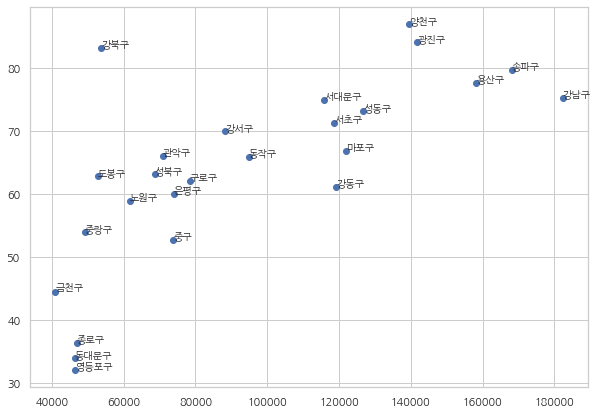

In [5]:
plt.figure(figsize=(10, 7))
plt.scatter(all_df.groupby('법정동명')['거래금액'].mean(), all_df.groupby('법정동명')['전용면적'].mean())

for x, y, n in zip(all_df.groupby('법정동명')['거래금액'].mean(),
                   all_df.groupby('법정동명')['전용면적'].mean(),
                   all_df.groupby('법정동명')['거래금액'].mean().index):
    plt.text(x+0.1, y+0.1, n, fontsize=10)